# Linear Neural Network - Logistic Regression (Linearly Separable Data)

In this notebook, we formulate the Logistic Regression technique for binary classification as a Linear Neural Network (LNN) model.

Using the LNN model, we perform binary classification on a **linearly separable** dataset (i.e., the Iris dataset). This is achieved by transforming the 3-class Iris dataset into a binary dataset. After training, we visualize the decision boundary to evaluate how well the model distinguishes between the two classes.

To create the LNN, we utilize the Keras API with TensorFlow 2.0 as the backend.

#### Note that we don't use a separate test set to evaluate the model's performance. Our goal here is to introduce how LNNs can be constructed and trained using the TensorFlow Keras API.

## Create Artificial Neural Networks (ANNs) using Keras

Keras is a high-level deep learning API that allows us to easily build, train, evaluate, and execute various types of ANNs. TensorFlow 2 has adopted Keras as its official high-level API: tf.keras.

We will use Keras to build the LNN, which involves two steps:

- Choose a suitable Keras model class and create the model using it.
- Add layers of different types based on the requirements.


### Step 1: Instantiate a Model using the Sequential API

The Sequential API provides a straightforward way to stack layers in a linear fashion. It is limited to single-input and single-output configurations. For more details, visit the Keras Sequential API documentation: https://keras.io/api/models/


### Step 2: Add Suitable Layers

Layers are the fundamental building blocks of neural networks in Keras. For more information, refer to the Keras Layers documentation: https://keras.io/api/layers/ 

To build an LNN, we primarily need to add Dense layers, which are the core layers in Keras. You can find more about Dense layers in the Keras **Dense Layer** documentation: https://keras.io/api/layers/core_layers/dense/

The Dense layer implements the operation: 

        output = activation(dot(input, kernel) + bias)

where the activation function is applied element-wise, the kernel is a weight matrix created by the layer, and the bias is a bias vector created by the layer (only applicable if use_bias is set to True).



The tf.keras.layers.Dense class includes the following parameters:

- units: Number of output neurons.

- activation (default: **"linear" activation**): Activation function to use.

- use_bias (default: **True**): Boolean, whether the layer uses a bias vector.

- kernel_initializer (default: **"glorot_uniform"**): Initializer for the kernel weights matrix.

- bias_initializer (default: **"zeros"**): Initializer for the bias vector.

- kernel_regularizer (default: None): Regularizer function applied to the kernel weights matrix.

- bias_regularizer (default: None): Regularizer function applied to the bias vector.

- activity_regularizer (default: None): Regularizer function applied to the output of the layer (its "activation").

- kernel_constraint (default: None): Constraint function applied to the kernel weights matrix.

- bias_constraint (default: None): Constraint function applied to the bias vector.


Note that by default Glorot Uniform weight initialization technique is used. Generally the **He initialization** works well with the ReLU activation function (kernel_initializer="he_normal") in deep ANNs. 

        For the LNN model, we will initialize the network weights with zero values and use the sigmoid activation function for binary classification and the softmax activation function for multi-class classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

## Decision Boundary: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points    
    y_pred_proba = clf.predict(X_new).reshape(x1.shape)

    y_pred = y_pred_proba
            
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if(y_pred_proba[i][j] >= 0.5):
                y_pred[i][j] = 1
            else:
                y_pred[i][j] = 0
        
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Synthetic Dataset: Linearly Separable


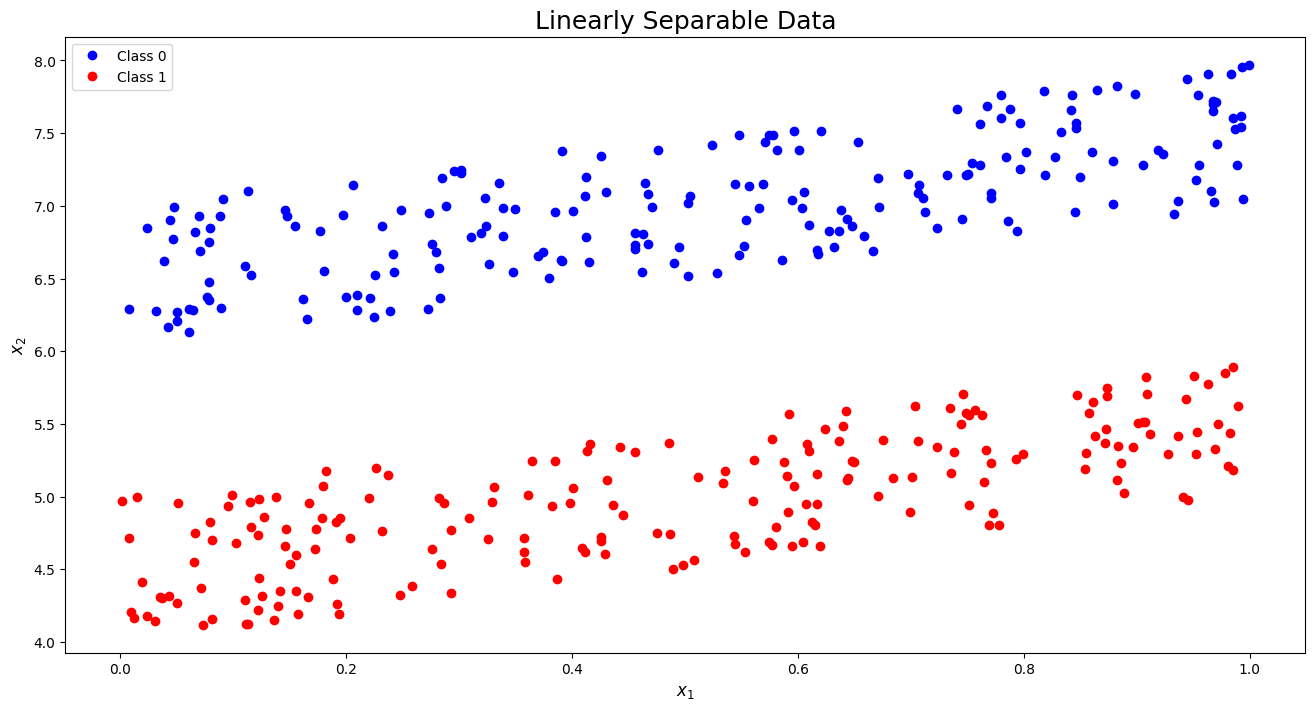

In [3]:
m0 = 200  # no. of training examples for class 0

# Generate class 0 data points randomly from a uniform distribution
#    Here a & b are 2 dimensions for each data (feature) point
a = np.random.rand(m0,1)
b = 4 + a + np.random.rand(m0,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((a, b), axis=1)

# Create the target vector for class 0 (target is coded with zeros)
X0_target = np.zeros((m0,), dtype=np.int32).reshape(-1, 1)

m1 = 200  # no. of training examples for class 1

# Generate class 1 data points randomly from a uniform distribution
#    Here c & d are 2 dimensions for each data (feature) point
c = np.random.rand(m1,1)
d = 6 + c + np.random.rand(m1,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 1
X1 = np.concatenate((c, d), axis=1)

# Create the target vector for class 1 (target is coded with ones)
X1_target = np.ones((m1,), dtype=np.int32).reshape(-1, 1)

# All training examples for class 0 and 1
X = np.append(X0, X1, axis=0)

# All target values for class 0 & 1
y = np.concatenate((X0_target, X1_target), axis=0)

# Create a 1D row vector ofthe target with float values
y = y.ravel()*1.0

# Draw a scatter plot
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.title("Linearly Separable Data", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
#plt.xticks(())
#plt.yticks(())
plt.show()

## Standardize the Dataset

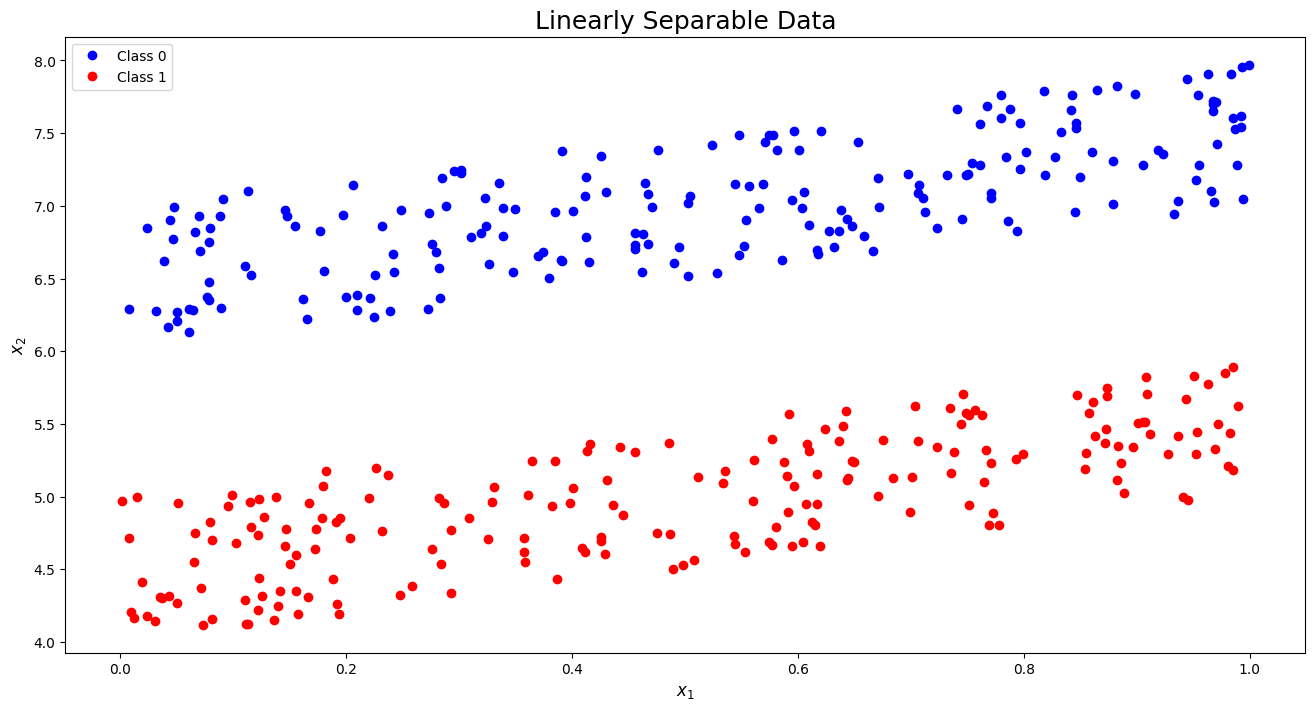

In [4]:
scaler = StandardScaler()

scaler.fit_transform(X)

# Draw a scatter plot
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.title("Linearly Separable Data", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
#plt.xticks(())
#plt.yticks(())
plt.show()

## Create a LNN Model

Using the Keras Dense layer we create a LNN model for Logistic Regression. **In a Dense layer, each neuron is connected to all input/neurons of the previous layer**.

The LNN model:
- has only one neuron.
- uses the logistic sigmoid function.

First, we need to specify the shape of the input using the Input layer, which instantiates a Keras tensor—a symbolic TensorFlow tensor.

- The "shape" parameter is a tuple of integers that defines the dimensionality of the input vectors. In this demo, the input is a 2D vector, so we use the tuple (2,). For image classification tasks, where inputs are matrices (e.g., a 28x28 image), the "shape" tuple would be (28, 28). Alternatively, if we flatten the input matrix (28x28=784), we would use the tuple (784,) to represent the dimensions of the flattened vector. Note that the batch size is not included in the shape definition.


In the Dense layer, we explicitly specify the "use_bias" parameter. By default, it is set to "True." If we change it to "False," the model will not learn the bias (i.e., "height" of the function in this 2D example). The purpose of explicitly showing the "use_bias" parameter is to highlight its impact on model learning.

- kernel_initializer: We initialize the weights (also known as the kernel) with zero values. In logistic or softmax regression, using initial zero weight values is acceptable. However, in nonlinear neural networks, such as Multi-layer Perceptrons (MLPs), it is crucial to use small random values for weight initialization. For this, we should employ sophisticated initializers like Glorot or He.

- activation: We use the logistic sigmoid activation function.



In [16]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_Binary_Classifier")
model.add(tf.keras.layers.Input(shape=[2, ]))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer="zeros", activation="sigmoid", use_bias=True))

model.summary()

Model: "LNN_Binary_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
CPU times: user 26.9 ms, sys: 6.39 ms, total: 33.3 ms
Wall time: 33.2 ms


## Compile & Train the LNN Model

A Keras model automatically employs the **backpropagation** algorithm to train an artificial neural network (ANN). However, we need to specify an optimization algorithm.

There are various advanced optimizers available, but for our LNN, we will use the **stochastic gradient descent (SGD)** optimizer, which requires setting an appropriate learning rate.

We will implement mini-batch SGD, so it's essential to specify both the batch size and the number of epochs.

### History Object
To monitor the performance of our model during training, we will utilize the tf.keras.callbacks.History object. This object automatically tracks key metrics, such as loss and accuracy, for each epoch across both training and validation datasets.

The History object is automatically applied when a model is trained using the fit() method in TensorFlow Keras. It records metrics, including:
- Loss for both training and validation data.
- Accuracy (or other metrics) for both training and validation data.

By analyzing this recorded history, we can assess the effectiveness of our training process and make necessary adjustments.

In [17]:
'''
Define the optimizer and loss function
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)


'''
Binary cross-entropy loss function:
If the output layer uses a sigmoid activation (which directly gives probabilities between 0 and 1), 
set from_logits=False. The output is already in the form of probabilities, 
so the loss function should not apply any additional transformations.
'''
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
#loss_fn = tf.keras.losses.MeanSquaredError()

'''
Compile the model
'''
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Set the epochs and batch size
'''
no_of_epochs = 80
size_of_mini_batch = 32


'''
Train the model
The History object is applied when a model is trained using the fit() method.
It automatically tracks the performance of a model during training. 
It records key metrics such as loss and accuracy for each epoch, for both training and validation data.
'''
history = model.fit(X, #  Feature data
                    y, # Target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
                   )

Epoch 1/80
13/13 [==============================] - 0s 499us/step - loss: 1.5682 - accuracy: 0.5550
Epoch 2/80
13/13 [==============================] - 0s 412us/step - loss: 1.7067 - accuracy: 0.5200
Epoch 3/80
13/13 [==============================] - 0s 404us/step - loss: 1.7084 - accuracy: 0.5350
Epoch 4/80
13/13 [==============================] - 0s 387us/step - loss: 1.8638 - accuracy: 0.4850
Epoch 5/80
13/13 [==============================] - 0s 446us/step - loss: 1.5999 - accuracy: 0.5300
Epoch 6/80
13/13 [==============================] - 0s 900us/step - loss: 1.4312 - accuracy: 0.6000
Epoch 7/80
13/13 [==============================] - 0s 400us/step - loss: 1.5681 - accuracy: 0.5200
Epoch 8/80
13/13 [==============================] - 0s 339us/step - loss: 1.6163 - accuracy: 0.4925
Epoch 9/80
13/13 [==============================] - 0s 439us/step - loss: 1.2319 - accuracy: 0.5625
Epoch 10/80
13/13 [==============================] - 0s 345us/step - loss: 0.9044 - accuracy: 0.6225

## Evaluate the LNN Model

In [18]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X, y, verbose=0))


y_predicted_proba = model.predict(X)

print(len(y_predicted_proba))

y_predicted = y_predicted_proba

for i in range(len(y_predicted)):
    if(y_predicted_proba[i] >= 0.5):
        y_predicted[i] = 1
    else:
        y_predicted[i] = 0


y_predicted = y_predicted.ravel()
accuracy = np.mean(y_predicted == y)
print("\nAccuracy: ", accuracy)



print("\nConfusion Matrix:")
print(confusion_matrix(y, y_predicted))

print("\nClassification Report:")
print(classification_report(y, y_predicted))

Epochs:  80

Test Data: Loss & Accuracy:  [0.06887529045343399, 1.0]
13/13 [==============================] - 0s 236us/step
400

Accuracy:  1.0

Confusion Matrix:
[[200   0]
 [  0 200]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## Plot The Decision Boundary

313/313 [==============================] - 0s 198us/step


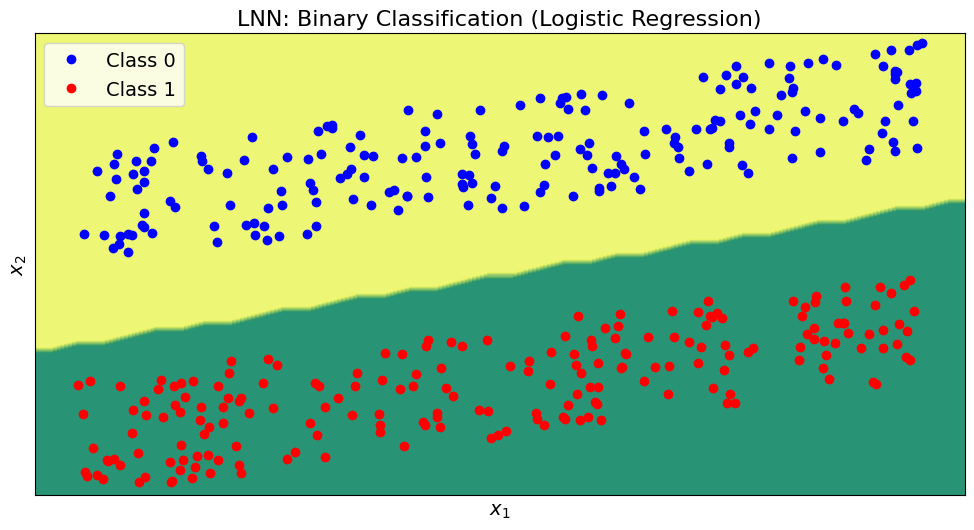

In [19]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.axis([-0.05, 1.05, 4, 8.05])

plt.show()